# Semi-Supervised Learning (SSL)


SSL studies how to learn from both labeled and unlabeled data, which can be useful when data is abundant but the resources to label them are limited.

In this exercise, you will:

* Given a simulated dataset with both labeled and unlabeled data, build a similarity graph and use the Harmonic Function Solution (HSF) to predict the labels of the unlabeled data;
* Use HSF for face recognition, given a fixed dataset;
* Implement an online version of HSF to label images as they appear in real time.

## 1. Harmonic Function Solution

Let $G = (V, E)$ be a weighted undirected graph where $V = \{x_1, \ldots, x_n \}$ is the vertex set and $E$ is the edge set. Each edge $e_{ij} \in E$ has a weight $w_{ij}$ and, if there is no edge between $x_i$ and $x_j$, then $w_{ij}=0$.

Let $|V| = n$ be the total number of nodes. Only a subset of the nodes $S \subset V$ with cardinality $|S| = l$ is labeled, and the remaining $u = n - l$ nodes are placed in the subset $T = V \setminus S$. 

Our goal is to predict the labels of the vertices in $T$ using the structure of the graph. Since we believe that nodes close in the graph should have similar labels, we would like to have each node surrounded by a majority of nodes with the same label. In order to do so, we impose that the labeling vector $f \in \mathbb{R}^n$ must be an **harmonic function** on the graph, that is:

$$
f_i = \frac{\sum_{j} w_{ij} f_j}{\sum_{j} w_{ij}},  \forall i \in T
$$

One interpretation for this constraint is that $w_{ij}$ represents the tendency of moving from node $x_i$ to node $x_j$, the stationary distribution of the transition matrix $P(j|i) = \tfrac{w_{ij}}{\sum_{k} w_{ik}}$  is a valid solution to our problem. 

### Hard HFS

It can be shown that $f$ is harmonic if and only if $(Lf)_T = 0$, where $(Lf)_T$ is the vector containing the values of $Lf$ for the nodes in the set $T$, and $L$ is the graph Laplacian. 

Hence, the harmonic function solution to the SSL problem is the solution to the following optimization problem:

$$
\min_{f \in \mathbb{R}^n}  f^T L f  
\quad \text{s.t} \quad
y_i = f(x_i) \quad \forall x_i \in S
$$
where $y_i$ are the labels available for the vertices $x_i \in S$. This gives us:

$$
f_T = L_{TT}^{-1}(W_{TS}f_S) = - L_{TT}^{-1}(L_{TS}f_S) 
$$

### Soft HFS

If the labels are noisy, we might need to replace the "hard" constraint of the optimization problem above by a "soft" constraint. Let $C$ be a diagonal matrix such that $C_{ii} = c_l$ for labeled examples and $C_{ii} = c_u$ otherwise. Also, define $y_i = 0$ for unlabeled examples, that is, for $x_i \in T$. 

The soft HFS objective function is

$$
\min_{f\in\mathbb{R}^n} (f-y)^T C (f-y) + f^T L f
$$
whose solution is 

$$
f^* = (C^{-1}L+I)^{-1}y
$$


### Implementation

Implement hard and soft HFS in the function `compute_hfs`. Complete the function `two_moons_hfs` to test your implementation using the datasets `data_2moons_hfs.mat` and `data_2moons_hfs_large.mat`.


* Tips: 
    * Don't forget to choose well the parameters to build the graph and its Laplacian.
    * You can use the functions `build_laplacian_regularized` and `build_similarity_graph`. The function `mask_labels` is used to chose how many labels are revealed.
    * Be careful: the labels are revealed randomly, and each random realization can have different results! Check how the `seed` parameter works.
    * Introduce noisy labels to compare hard and soft HFS.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as sd
from scipy.io import loadmat
import os
from helper import build_similarity_graph, label_noise
from helper import build_laplacian, build_laplacian_regularized
from helper import plot_classification
from helper import mask_labels

In [2]:
"""
Define parameters for HFS
"""
params = {}

# regularization parameter (gamma)
params['laplacian_regularization'] = 0.0

# the sigma value for the exponential (similarity) function, already squared
params['var'] = 1.0

# Threshold eps for epsilon graphs
params['eps'] = None

# Number of neighbours k for k-nn. If zero, use epsilon-graph
params['k'] = 12

# String selecting which version of the laplacian matrix to construct.
# 'unn':  unnormalized, 'sym': symmetric normalization, 'rw':  random-walk normalization 
params['laplacian_normalization'] = 'unn'

# Coefficients for C matrix for soft HFS
params['c_l'] = 1
params['c_u'] = 0.1

In [3]:
def compute_hfs(L, Y, soft=False, **params):
    """
    TO BE COMPLETED

    Function to perform HFS (hard or soft!).
    
    Parameters
    ----------
    L : array
        Graph Laplacian, (n x n) matrix (regularized or not)
    Y : array
        (n, ) array with nodes labels [0, 1, ... , num_classes] (0 is unlabeled)
    soft : bool
        If True, compute soft HFS. Otherwise, compute hard HFS.

    Returns
    --------
        Labels, class assignments for each of the n nodes
    """

    num_samples = L.shape[0]
    Cl = np.unique(Y)
    num_classes = len(Cl)-1

    """
    Build the vectors:
    y = (n x num_classes) target vector 
    l_idx = shape (l,) vector with indices of labeled nodes
    u_idx = shape (u,) vector with indices of unlabeled nodes
    """
    # ...
    l_idx = Y != 0
    u_idx = Y ==0
    
    # we encode using the solution provided here https://stackoverflow.com/questions/38592324/one-hot-encoding-using-numpy 
    target_indices = (Y[l_idx]-1).astype(int)    
    y = np.zeros((num_samples,num_classes))
    M = 2*np.eye(num_classes)-np.ones((num_classes,num_classes))
    
    y[l_idx]= M[target_indices]
    
    if not soft:    
        """
        Compute hard HFS.  

        f_l = solution for labeled data. 
        f_u = solution for unlabeled data
        f   = solution for all data
        """
        
        f_l = M[target_indices]
        f_u = - np.linalg.inv(L[:,u_idx][u_idx])@(L[:,l_idx][u_idx]@f_l)
        f = np.zeros((num_samples,num_classes))
        f[l_idx]=f_l
        f[u_idx]=f_u
        
    else:
        """
        Compute soft HFS.
        f = harmonic function solution 
        C = (n x n) diagonal matrix with c_l for labeled samples and c_u otherwise    
        """
        u = np.zeros(L.shape[0]) 
        u[l_idx] = params['c_l']
        u[u_idx] = params['c_u']
        C = np.diag(u)         
        f = np.linalg.inv(np.linalg.inv(C)@L + np.eye(num_samples))@y 

    """
    return the labels assignment from the hfs solution, and the solution f
    labels: (n x 1) class assignments [1,2,...,num_classes]    
    f : harmonic function solution
    """
    labels = np.argmax(f,axis=1)+1
    return labels, f


In [4]:
def two_moons_hfs(l=4, l_noisy=1, soft=False, dataset='data_2moons_hfs.mat', plot=True, seed=None, **params):
    """    
    TO BE COMPLETED.

    HFS for two_moons data.
    
    Parameters
    ----------
    l : int
        Number of labeled (unmasked) nodes provided to the HFS algorithm.
    l_noisy : int
        Number of *noisy* labels to introduce.
    soft : bool
        If true, use soft HFS, otherwise use hard HFS
    dataset : {'data_2moons_hfs.mat' or 'data_2moons_hfs_large.mat'}
        Which dataset to use.
    plot : bool
        If True, show plots
    seed : int
        If not None, set global numpy seed before choosing labels to reveal.
    """
    if seed is not None:
        np.random.seed(seed)

    # Load the data. At home, try to use the larger dataset.    
    in_data = loadmat(os.path.join('data', dataset))
    X = in_data['X']
    Y = np.array(in_data['Y'].squeeze(), dtype=np.uint32)

    # infer number of labels from samples
    num_samples = np.size(Y, 0)
    unique_classes = np.unique(Y)
    num_classes = len(unique_classes)
    
    # mask labels
    Y_masked = mask_labels(Y, l)
    assert len(np.unique(Y_masked)) > 2, "only one class in training data!"
    # introduce noise
    noise_indices = np.where(Y_masked == 0)[0]
    np.random.shuffle(noise_indices)
    noise_indices = noise_indices[:l_noisy]
    Y_masked[noise_indices] = np.random.choice(unique_classes, l_noisy)
    """
    compute hfs solution using either soft_hfs or hard_hfs
    """
    # Build graph Laplacian using the parameters:
    # params['laplacian_regularization'], params['var'], params['eps'], 
    # params['k'] and params['laplacian_normalization'].
    
    L = build_laplacian_regularized(
        X = X,
        laplacian_regularization = params['laplacian_regularization'],
        var = params['var'],
        eps = params['eps'],
        k = params['k'],
        laplacian_normalization=  params['laplacian_normalization']
    )
    

    labels, f = compute_hfs(L, Y_masked, soft, **params)
    # Visualize results
    if plot:
        plot_classification(X, Y, Y_masked, noise_indices, labels, params['var'], params['eps'], params['k'])
    accuracy = np.mean(labels == np.squeeze(Y))
    print(f"Soft={soft}, Accuracy={accuracy}")
    return X, Y, labels, accuracy


### Question 1.1 - Report the accuracy you obtained for `data_2moons_hfs.mat` dataset using hard HFS, when l=10 and l_noisy=0. 

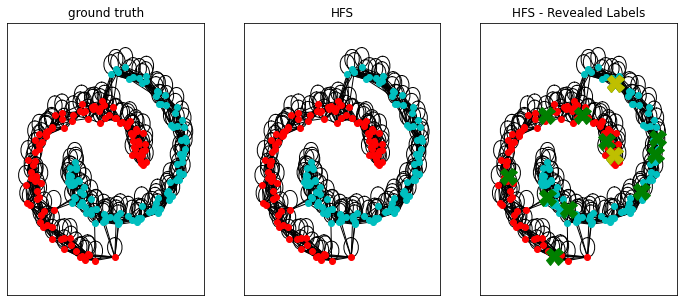

Soft=False, Accuracy=1.0


In [5]:
seed = 42
X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=2, soft=False, dataset='data_2moons_hfs.mat',
                                                 plot=True, seed=seed, **params)

### Question 1.2  - Using `data_2moons_hfs_large.mat`, run `two_moons_hfs` several times with l=4. What can go wrong?

* Tips:
    * When running `two_moons_hfs` several times, don't forget to set `seed=None`

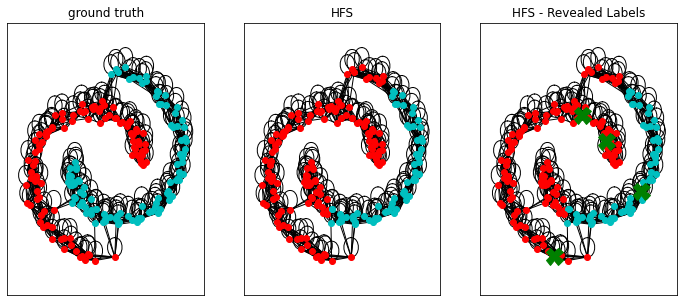

Soft=False, Accuracy=0.815


In [6]:
seed = 42
X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=4, l_noisy=0, soft=False, dataset='data_2moons_hfs.mat',
                                                 plot=True, seed=seed, **params)

In [7]:
#np.random.seed(42)
for ii in range(20):
     X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=4, l_noisy=0, soft=False, 
                                                      dataset='data_2moons_hfs_large.mat',
                                                      plot=False, seed=None, **params)
    
# mask_labels? # check parameters

AssertionError: only one class in training data!

With so few labels what can happen is that all revaled labels are of the same class. This is problematic as a solution of the problem is to assign all labels to the same revealed class. 

### Question 1.3 - Using `data_2moons_hfs.mat`, l=10 and l_noisy=5, compare hard HFS to soft HFS. Report the accuracy and comment the results.

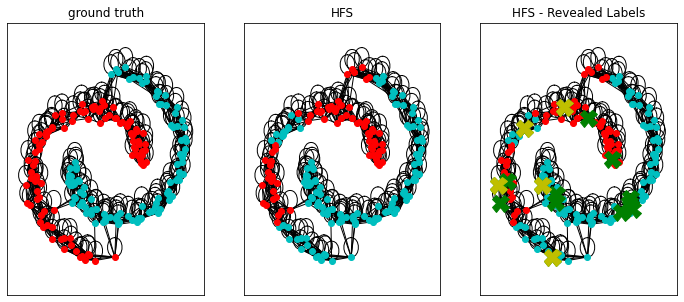

Soft=False, Accuracy=0.825


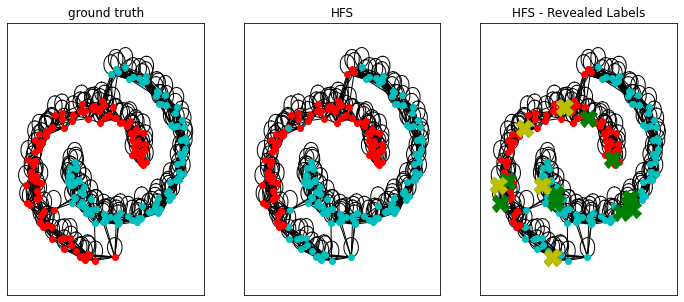

Soft=True, Accuracy=0.9


In [400]:
# Comparing
seed = 5  # To run several times with random outcomes, set seed=None. Otherwise, set a seed for reproducibility.
plot = True 
dataset = 'data_2moons_hfs.mat' # Try also 'data_2moons_hfs_large.mat'

X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=False, dataset=dataset,
                                                 plot=plot, seed=seed, **params)
X, Y, soft_labels, soft_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=True, dataset=dataset,
                                                 plot=plot, seed=seed, **params)

We can see that Soft HFS usually performs better with noisy data (the accuracy of Soft HFS is 0.1 higher than the accuracy of Hard HFS. This is because the hard constraints of Hard HFS cannot always be respected when there are noisy labels.

## 2. Face recognition with HFS

Now, we apply HFS to the task of face recognition, that is, our goal is to classify faces as belonging to different people. Since faces all share common features, it can be a good idea to leverage a large quantity of unlabeled data to improve classification accuracy. In this part of the exercise, you will:

* Extract faces from the images using OpenCV for face detection, and use the same library to apply preprocessing steps;
* Run HFS for classification.

### Implementation

Choose the hyperparameters and run HFS for face recognition, using both the small and large dataset. You can try to change the preprocessing steps (e.g. equalizeHist, GaussianBlur) applied to the images.

**Important**: make sure your HFS code is able to handle more than two classes!

### Question 2.1 - How did you manage to label more than two classes?

We one-hot encode the labels so that each column represents the presence or not of one label. Instead of having one vector $f$ we have a matrix $f$ where each coloumn $i$ corresponds to label $i$. We encode the presence of the label with $1$, we encode the presence of other labels with $-1$, and we encode the absence of any label with $0$, so that each column corresponds to the test of a label against the others, and we are back to the situation seen in class. To determine the labels of the unlabeled nodes we then take the argmax of its row in f, wich corresponds to the most likely label for this node.


### Question 2.2 - Report the best accuracy you obtained for both (small and augmented) datasets.

* Tips:
    * The small dataset (10 images per person) is loaded with `load_image_data`.
    * Use `load_image_data_augmented` for the augmented dataset (50 images per person). 



 We used laplacian regularization = 0.5, var = 100, created a $\epsilon=1$ graph, used un-normalized laplacian, removed all filters from the pre-processing steps and locally equalized histograms in a window of $(7,7)$
For the seed 504, the best accuracy we obtained was 0.88 on the small dataset and 0.636 on the augmented dataset.

### Question 2.3 - If the accuracy changes when using the augmented dataset, explain why. Does using additional data always increase the performance?

The number of unmasked labels is the same for the two datasets, even though the augmented dataset has 50 images per person instead of 10. If we take the random walk approach seen in class, the harmonic function can be computed by an iteration of computations for each label until convergence. If there is a fewer percentage of labels, it means that there are more masked labels and that therefore values of the harmonic function are propagated with less precision for nodes "far away" fromlabeled nodes. This can lead to important labeling errors and explains why the accuracy for the larger dataset is smaller.

In [8]:
import matplotlib.pyplot as plt
from imageio import imread
import numpy as np
import cv2
import os

from load_images import load_image_data, plot_image_data
from load_images import load_image_data_augmented, plot_image_data_augmented

In [9]:
"""
Define parameters for face recognition with HFS
"""
params_face_rec = {}
params_face_rec['laplacian_regularization'] = 0.5
params_face_rec['var'] = 100.0
params_face_rec['eps'] = 1
params_face_rec['k'] = None
params_face_rec['laplacian_normalization'] = 'unn'
params_face_rec['c_l'] = 0.9
params_face_rec['c_u'] = 0.1

In [10]:
# Function to preprocess the images
# You may try to change it and check the impact on the classification accuracy
def preprocess_image(image):
    """
    Parameters
    ----------
    image : array
        (width, height) array representing a grayscale image
    
    Returns
    -------
        (96, 96) preprocessed image
    """
    output_frame_size = 96   # do not change the output frame size!
    #image = cv2.bilateralFilter(image, 9, 75, 75)
    #image = cv2.equalizeHist(image)
    clahe = cv2.createCLAHE(tileGridSize=(7,7)) 
    image = clahe.apply(image)
    #image = cv2.GaussianBlur(image, (5, 5), 0)
    #image = cv2.medianBlur(image, 3)
    im = cv2.resize(image, (output_frame_size, output_frame_size)).astype(np.float)
    im -= im.mean()
    im /= im.max()
    image = im
    return image

C:\Users\gabri\AppData\Local\Temp/ipykernel_54836/480780062.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im = cv2.resize(image, (output_frame_size, output_frame_size)).astype(np.float)


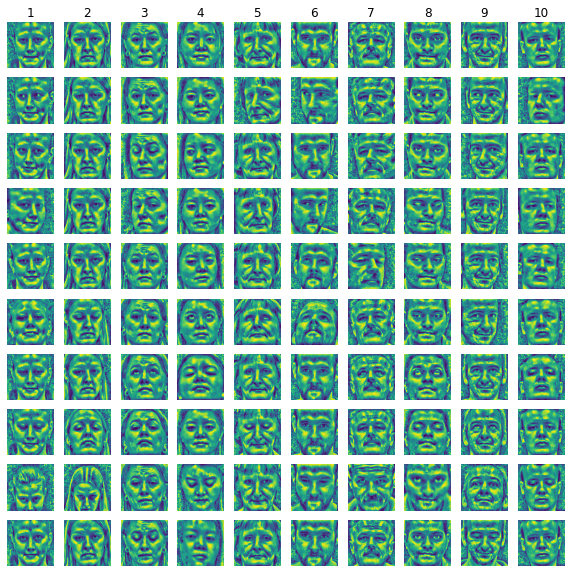

(100, 9216)
[[ 0.  2.  3.  0.  5.  6.  0.  8.  0. 10.]
 [ 0.  0.  3.  0.  5.  6.  0.  0.  9. 10.]
 [ 1.  0.  0.  0.  5.  6.  0.  8.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  9. 10.]
 [ 1.  0.  3.  0.  0.  0.  7.  0.  0.  0.]
 [ 0.  0.  0.  4.  0.  0.  0.  0.  9.  0.]
 [ 0.  0.  0.  4.  0.  0.  7.  8.  9.  0.]
 [ 0.  2.  3.  4.  0.  0.  7.  0.  0. 10.]
 [ 0.  2.  0.  4.  0.  6.  7.  0.  0.  0.]
 [ 1.  2.  0.  0.  5.  0.  0.  8.  0.  0.]]


In [11]:
# 10 images per person
np.random.seed(504)   # set seed, since labels are masked randomly
images, labels, masked_labels = load_image_data(preprocess_image)
# # 50 images per person
# images_a, labels_a, masked_labels_a = load_image_data_augmented(preprocess_image)
# plot_image_data_augmented(images_a)

# Uncomment below if you want to visualize the images
plot_image_data(images)
print(images.shape)
print(masked_labels.reshape(-1, 10))

In [12]:
# graph Laplacian
L = build_laplacian_regularized(images, 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])
print(L.shape)

(100, 100)


Accuracy =  0.88
[ 0.  2.  3.  0.  5.  6.  0.  8.  0. 10.  0.  0.  3.  0.  5.  6.  0.  0.
  9. 10.  1.  0.  0.  0.  5.  6.  0.  8.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  9. 10.  1.  0.  3.  0.  0.  0.  7.  0.  0.  0.  0.  0.  0.  4.
  0.  0.  0.  0.  9.  0.  0.  0.  0.  4.  0.  0.  7.  8.  9.  0.  0.  2.
  3.  4.  0.  0.  7.  0.  0. 10.  0.  2.  0.  4.  0.  6.  7.  0.  0.  0.
  1.  2.  0.  0.  5.  0.  0.  8.  0.  0.]
[ 1  2  3  4  5  6  7  8  9 10  1  2  3  4  5  6  7  8  9 10  1  2  3  3
  5  6 10  8  9 10  1  2 10  4 10  9 10  8  9 10  1  2  3  4  5  6  7  8
  9 10 10  2  3  4  5  4  7  8  9 10  1  2  3  4  5  6  7  8  9  3  1  2
  3  4  5  6  7  8  1 10  4  2  3  4  5  6  7  8  4 10  1  2  3  4  5  6
  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10  1  2  3  4  5  6  7  8  9 10  1  2  3  4
  5  6  7  8  9 10  1  2  3  4  5  6  7  8  9 10  1  2  3  4  5  6  7  8
  9 10  1  2  3  4  5  6  7  8  9 10  1  2  3  4  5  6  7  8  9 10  1  2
  3  4  5  6  7  8  9 10  1  2  3  4  5  6  7  8  9

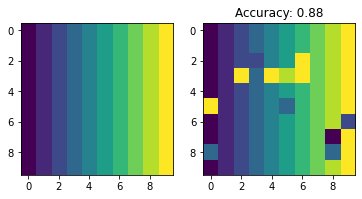

In [13]:
# Run HFS
predicted_labels, f = compute_hfs(L, masked_labels, soft=False, **params_face_rec)
accuracy = np.equal(predicted_labels, labels).mean()
print("Accuracy = ", accuracy)

print(masked_labels)
print(predicted_labels)
print(labels)
# Visualize predicted vs true labels
plt.subplot(121)
plt.imshow(labels.reshape((-1, 10)))
plt.subplot(122)
plt.imshow(predicted_labels.reshape((-1, 10)))
plt.title("Accuracy: {}".format(accuracy))
plt.show()

### Augmented dataset

In [407]:
np.random.seed(456)
images_augmented, labels_augmented, masked_labels_augmented = load_image_data_augmented(preprocess_image)

C:\Users\gabri\AppData\Local\Temp/ipykernel_25348/480780062.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im = cv2.resize(image, (output_frame_size, output_frame_size)).astype(np.float)


In [408]:
# graph Laplacian
L_augmented = build_laplacian_regularized(images_augmented, 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])

In [409]:
# Run HFS
predicted_labels_augmented, f_augmented = compute_hfs(L_augmented, masked_labels_augmented, soft=True, **params_face_rec)
accuracy_augmented = np.equal(predicted_labels_augmented, labels_augmented).mean()
print("Accuracy = ", accuracy_augmented)


Accuracy =  0.636


[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  6.
  7.  0.  0.  0.  0.  0.  0.  0.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  8.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  9.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  5.  0.  0.  0.  0.  0.  0.  0.  0.  4.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  6.  0.  0.  0. 10.  0.  0.  0.  0.  0.  6.  0.  0.  0.  0.  1.  0.
  3.  0.  0.  0.  0.  0.  9.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 10.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  4.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

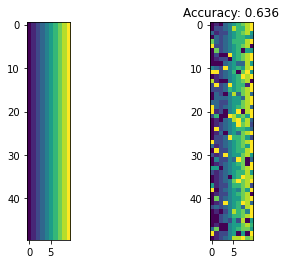

In [410]:
print(masked_labels_augmented)
plt.subplot(121)
plt.imshow(labels_augmented.reshape((-1, 10)))
plt.subplot(122)
plt.imshow(predicted_labels_augmented.reshape((-1, 10)))
plt.title("Accuracy: {}".format(accuracy_augmented))
plt.show()

## 3. Online SSL

Now, instead of having all the data available at once, images will be received online: at each time $t$, a new image $x_t$ is observed and the algorithm has to output a label $y_t$. 

Use the function `create_user_profile` to capture a training set of labeled data (of your face and someone else). The faces will be preprocessed and saved in the folder `data/faces`. They will be loaded by `online_face_recognition`.


### Implementation

Choose the hyperparameters and complete the functions `online_ssl_update_centroids` and `online_ssl_compute_solution`. 

Modify your code to be able to disregard faces it cannot recognize.

* Tips:
    * You can use the functions `build_similarity_graph` and `build_laplacian`.

### Question 3.1 - Attach to this notebook some of the resulting frames of online face recognition. 

<img src="results/frame.png">


    
### Question 3.2 - What strategy did you use to label a face as unknown? Attach to this notebook an example of a unknown face being correctly labeled as unknown.

Let $f_{ki}$ be the prediction for label $i$ for the face $k$. As we saw in class the prediction $f_{ki}=|f_{ki}| \cdot sgn(f_{ki})$, meaning that the prediction is equal to the confidence $|f_{ki}|$ times the label $sgn(f_{ki})$ it believes is associated to face $k$.  If the highest probability of the row of an unlabeled face is low, it means that the confidence that any label is associated to this face is low, and therefore this face is unknown. Therefore for a face, if the highest probability is lower than $0.6$, we classify it as unknown.


In [411]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os
import sys
from scipy.spatial import distance
import scipy.io as sio

from helper_online_ssl import create_user_profile, online_face_recognition

In [412]:
"""
Define parameters for face recognition with HFS
"""
params_online_ssl = {}
params_online_ssl['laplacian_regularization'] = 0.2
params_online_ssl['var'] = 10000.0
params_online_ssl['eps'] = None
params_online_ssl['k'] = None
params_online_ssl['laplacian_normalization'] = 'unn'
params_online_ssl['c_l'] = 0.95
params_online_ssl['c_u'] = 0.05

In [413]:
class IncrementalKCenters:
    def __init__(self, labeled_faces, labels, label_names, max_num_centroids=100):
        #  Number of labels
        self.n_labels = max(labels)

        #  Dimension of the input image
        self.image_dimension = labeled_faces.shape[1]

        #  Check input validity
        assert (set(labels) == set(
            range(1, 1 + self.n_labels))), "Initially provided faces should be labeled in [1, max]"
        assert (len(labeled_faces) == len(labels)), "Initial faces and initial labels are not of same size"

        #  Number of labelled faces
        self.n_labeled_faces = len(labeled_faces)

        # Model parameter : number of maximum stored centroids
        self.max_num_centroids = max_num_centroids

        # Model centroids (inital labeled faces). Shape = (number_of_centroids, dimension)
        self.centroids = labeled_faces

        # Centroids labels
        self.Y = labels
        
        # Label names (= user names)
        self.label_names = label_names

        # Variables that are initialized in online_ssl_update_centroids()
        self.centroids_distances = None
        self.taboo = None
        self.V = None
        self.init = True

        # index of x_t (initialized later)
        self.last_face = None
    
        self.flag = 0 # self.flag corresponds to the number of consecutive "unknown" labels necessary to create a new label
        self.new_label = False
        self.new_faces = 0
        
    def initialize(self):
        """
        Initialization after the first time that the maximum number of centroids is reached.
        """       
        #  Compute the centroids distances
        self.centroids_distances = distance.cdist(self.centroids, self.centroids)

        #  set labeled nodes and self loops as infinitely distant, to avoid merging labeled centroids
        np.fill_diagonal(self.centroids_distances, +np.Inf)
        self.centroids_distances[0:self.n_labeled_faces, 0:self.n_labeled_faces] = +np.Inf

        # put labeled nodes in the taboo list
        self.taboo = np.array(range(self.centroids.shape[0])) < self.n_labeled_faces

        # initialize multiplicity
        self.V = np.ones(self.centroids.shape[0])
        

    def online_ssl_update_centroids(self, face):
        """
        TO BE COMPLETED

        Update centroids, multiplicity vector V, labels Y.
        
        Note: In Y, set label to 0 for unlabeled faces.

        Parameters
        ----------
        face : array
            New sample
        
        Returns
        --------
        List with the scores for each possible label:
            [(label_1, score_1), (label_2, score_2), ...]
        """
        
        assert (self.image_dimension == len(face)), "new image not of good size"

        # Case 1: maximum number of centroids has been reached.
        if self.centroids.shape[0] >= self.max_num_centroids + 1:
            if self.init:
                #  Initialization after the first time that the maximum number of centroids is reached
                self.initialize()
                self.init = False
            """
            Find c_rep and c_add following Algorithm 1.
            
            - c_1, c_2 = two closest centroids (minimum distance) such that at least one of them is not in self.taboo.
            - c_rep = centroid in {c_1, c_2} that is in self.taboo. If none of them is in self.taboo, c_rep is the one
                      with largest multiplicity.
            - c_add = centroid in {c_1, c_2} that is not c_rep.
            """
        
            c_rep, c_add = None, None
            num_centroid = self.centroids.shape[0]
            not_taboo =np.array(range(self.centroids.shape[0])) >= self.n_labeled_faces
            if len(not_taboo)>0 : 
                sorted_dist_centroid = np.argsort(self.centroids_distances[not_taboo].ravel())  
            else :
                sorted_dist_centroid = np.argsort(self.centroids_distances.ravel())
            ind=sorted_dist_centroid[0]
            c_1 = ind//num_centroid 
            c_2 = ind%num_centroid
            
            if c_1 in self.taboo:
                c_rep = c_1
                c_add = c_2
            elif c_2 in self.taboo:
                c_add = c_1
                c_rep = c_2
            elif self.V[c_2] <= self.V[c_1]:
                c_rep = c_1
                c_add = c_2
            else:
                c_add = c_1
                c_rep = c_2
            

            """
            Update data structures: self.centroids and self.V
            """
            self.centroids[c_add,:] = face 
            self.V[c_rep] += self.V[c_add]
            self.V[c_add] = 1


            """
            Update the matrix containing the distances.
            """
            dist_row = distance.cdist(np.array([self.centroids[c_add]]), self.centroids)[0]
            dist_row[c_add] = +np.inf
            self.centroids_distances[c_add, :] = dist_row
            self.centroids_distances[:, c_add] = dist_row
            self.last_face = c_add

        # Case 2: create new centroid with face
        # Remark: the multiplicities vector self.V is initialized in self.initialize()
        else:
            current_len = len(self.centroids)
            self.Y = np.append(self.Y, 0)
            self.centroids = np.vstack([self.centroids, face])

    def online_ssl_compute_solution(self):
        """
        TO BE COMPLETED.

        Returns a prediction corresponding to self.last_face.
        """

        # Multiplicity matrix
        if self.init:
            V = np.diag(np.ones(self.centroids.shape[0]))
            self.last_face = self.centroids.shape[0] - 1
        else:
            V = np.diag(self.V)
            
        # Build quantized graph and its regularized Laplacian
        
        W = build_similarity_graph(self.centroids,
                                   var = params_online_ssl['var'],
                                   eps = params_online_ssl['eps'],
                                   k = params_online_ssl['k']
                                  )
        W = V@W@V 
        L = build_laplacian(W, laplacian_normalization =  params_online_ssl['laplacian_normalization'])
        Q = L + params_online_ssl['laplacian_regularization']*np.eye(L.shape[0])

        # Compute the hard HFS solution f. 
        labels, f = compute_hfs(Q, self.Y, soft=False, **params_online_ssl)

        # Return the score for each possible label
        num_classes = len(np.unique(self.Y))-1 
        label_scores = []
        for ii in range(num_classes):
            label = self.label_names[ii]
            score = f[self.last_face, ii]
            label_scores.append((label, score))

            # handle unknown faces
        # ...
        f_last = f[self.last_face,:]
        score_last=np.max(f_last)
        if score_last < 0.6 :
            label_scores.append(("unknown", score_last))
            if self.init==False :
                self.flag+=1
        else :
            # unless it's an old label, we don"t put the flag to 0 as we want to keep putting more labels for stability 
            if self.new_label==False:
                self.flag=0 
            else :
                self.flag+=1
        
        # create one new face, with one new face name, 
        if ((self.flag == 117) and (self.init==False) and (self.n_labeled_faces < self.max_num_centroids - 5)):
            self.n_labels+=1
            self.new_faces+=1
            self.label_names.append("New face "+str(self.new_faces))
            self.taboo[self.last_face]=True
            self.Y[self.last_face]=self.n_labels
            self.n_labeled_faces +=1
            label_scores[-1] = ("New face "+str(self.new_faces),label_scores[-1][1])
            self.centroids_distances[self.taboo, self.taboo] = +np.Inf
            self.new_label = True # to not put the flag to 0 
            
            
        # if the newt 4 labels are unknown, add them as labels of the new face 
        # this adds a bit of stability as they are surely of the same label than the one detected
        # we put the condition that there must always be 5 non labeled nodes in f,
        # and that the initialization must have been made
        
        if (( 117 <  self.flag < 122) and (self.init==False) and (self.n_labeled_faces < self.max_num_centroids - 5)) :
            self.taboo[self.last_face]=True
            self.Y[self.last_face]=self.n_labels
            self.n_labeled_faces +=1
            label_scores[-1] = ("New face "+str(self.new_faces),label_scores[-1][1])
            self.centroids_distances[self.taboo, self.taboo] = +np.Inf
            
        # stop labeling, put flag to 0 and start again
        elif self.flag == 122 :
            self.flag = 0 #restart new labeling
            self.new_label = False
            
            
            
            
            
        return label_scores

In [161]:
create_user_profile('Gabriel')       


Profile found with 20 images.


In [24]:
create_user_profile('Marius')   

Profile found with 20 images.


In [414]:
 online_face_recognition(['Maman','Gabriel','Marius'], IncrementalKCenters, n_pictures=20)

Profile found with 20 images.
Profile found with 20 images.
Profile found with 20 images.


### Question 4.1 - You can now classify faces as either known (i.e. belong to a class) or unknown (i.e. belong to no class). How would you modify the algorithm to automatically learn to classify new classes? That is, how can you modify the algorithm so that faces that appear unfrequently are labeled as unknown, but once a specific face has been seen enough times it gets assigned an automatic label (e.g. AutoBob) and from that point it is treated as a new class. 

When the last n ("memory parameter", =117 in code) labels are labeled to "unknown", we turn c_add to true in self.taboo, and we add a label in c_add position in Y. This means that we add a new label corresponding to this face. The trick that I implemented to increase stability is that we also label the four unknown labels that follow a new labeling. With this trick, after a few seconds the algorithm has no difficulty recognizing the new face as it has several labels it can use to classify. For the condition of classification, I was careful of classifying only if there is enough space for unlabeled centroids in the memory matrix, and only if there has been an initialization so that we don't add labels at the very beginning of the process. 

Something interesting to note is that as the algorithm needs time to cross the 0.6 value, it will assign a new label to any face it sees, even to an already labeled face. Then from these new labels that correspond exactly to the environment (background/light/proximity to camera) in which are taken the pictures, all photos will be assigned to this new face. In practice we therefore need to take a large memory parameter.  
    
### Question 4.2 - In class we considered different kinds of metric for (semi) supervised learning. Looking at the face classification task, try to quantify how the offline-online, exact-quantized, and inductive-transductive axes influence each other. In particular given $l$ labeled faces, $u = N - l$ unlabeled faces, and $m$ extra/test faces design an experimental study to quantify these trade-offs, both in terms of transductive and inductive error, as well as online/batch error. Examples of combinations that can be used to study these axes are:
* Supervised vs Semi-supervised
    * A comparison between a supervised learner (of your choice) trained on the $l$ labeled faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces.
* Inductive vs Transductive
    * A comparison between a supervised learner (of your choice) trained on the $l$ labeled faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces evaluated on the $N$ revealed points and then on the $m$ unrevealed points.
* Supervised vs Semi-supervised and Inductive vs Transductive
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces, evaluated on the $N$ revealed points and then on the $m$ unrevealed points.
* Online vs Batch
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled faces and an online supervised learner (of your choice) trained revealing the $N$ labels one at a time
* Exact vs Quantized
    * A comparison between a semi-supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces using a certain memory budget, and the same learner with a constrained memory budget.
* Exact vs Quantized and Online vs Batch and Inductive vs Transductive
    * A comparison between a semi-supervised online learner (of your choice) trained with and without quantization, evaluated both on the $N$ faces revealed during training, and $m$ faces unrevealed. You can further compare the online performance of the learner against the performance of an "hindsight" learner that saw the labels all at once

# Supervised vs Semi-supervised and Inductive vs Transductive

The strength of transductive learning with semi supervised learning seems to be that it can learn labels with very few data, as we saw with the augmented images dataset. Therefore we will analyse the performances of supervised and semi supervised learners based on the quantity of information that they have in the training set. For supervised learning, the training set consists of labeled nodes, and the test set consists of unlabeled nodes. We fit on the training set and predict on the test set. For semi supervised learning, labeled nodes are in the training set and unlabeled nodes are in the test set. The algorithm uses all the trainset and test set jointly to label the test set. We will analyse and plot performances of both learners in terms of computation time and accuracy depending on the size of the training set. 

## supervised learning

#### We shuffle then split the augmented images into a training set and validation set, we fit on the training set and test on the validation set.

In [415]:
np.random.seed(456)
images_a, labels_a, masked_labels_a = load_image_data_augmented(preprocess_image)

C:\Users\gabri\AppData\Local\Temp/ipykernel_25348/480780062.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im = cv2.resize(image, (output_frame_size, output_frame_size)).astype(np.float)


In [416]:
from sklearn.utils import shuffle
import time
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm

In [417]:
images_a_shuffle, labels_a_shuffle = shuffle(images_augmented, labels_augmented, random_state=1)
ind1=400
print(images_a_shuffle.shape)
print(labels_a_shuffle.shape)



(500, 9216)
(500,)


In [418]:
time_start = time.time()
clf31 = MLPClassifier(hidden_layer_sizes = (20,20), random_state=1, early_stopping=True).fit(images_a_shuffle[:ind1], labels_a_shuffle[:ind1])


#### We test our learner on the validation set

In [419]:
labels_predicted_supervised = clf31.predict(images_a_shuffle[ind1:])

accuracy_augmented = np.equal(labels_predicted_supervised, labels_a_shuffle[ind1:]).mean()
print("Accuracy = ", accuracy_augmented)
print('execution time = ', time.time()-time_start)

Accuracy =  0.87
execution time =  1.1630597114562988


## Semi supervised learning

In [420]:
# graph Laplacian
L_a = build_laplacian_regularized(images_a_shuffle, 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])

In [421]:
# Run HFS
time_start = time.time()
test_labels = np.zeros(labels_a.shape)
test_labels[:ind1]=labels_a_shuffle[:ind1]
predicted_labels_unsupervised, f_a = compute_hfs(L_a, test_labels, soft=True, **params_face_rec)
accuracy_augmented = np.equal(predicted_labels_unsupervised[ind1:], labels_a_shuffle[ind1:]).mean()
print("Accuracy = ", accuracy_augmented)
print('execution time = ', time.time()-time_start)

Accuracy =  0.89
execution time =  0.08824276924133301


## Comparaison of performances for varying ind1

In [422]:
print(np.linspace(0,1,21))

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


In [423]:
time_start = time.time()
clf = MLPClassifier(hidden_layer_sizes = (20,20), random_state=1, early_stopping=True)
accuracy_supervised = []
for i in tqdm(np.linspace(0,1,21)[1:-1]) :
    ind1 = int(i*500)
    clf.fit(images_a_shuffle[:ind1], labels_a_shuffle[:ind1])
    labels_predicted_supervised = clf.predict(images_a_shuffle[ind1:])
    accuracy_augmented = np.equal(labels_predicted_supervised, labels_a_shuffle[ind1:]).mean()
    accuracy_supervised.append(accuracy_augmented)
print('execution time = ', time.time()-time_start)
    

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.24it/s]

execution time =  15.315783023834229


In [424]:
time_start = time.time()
accuracy_semi_supervised = []
for i in tqdm(np.linspace(0,1,21)[1:-1]) :
    ind1 = int(i*500)
    test_labels = np.zeros(labels_a.shape)
    test_labels[:ind1]=labels_a_shuffle[:ind1]
    predicted_labels_semi_supervised, f_a = compute_hfs(L_a, test_labels, soft=True, **params_face_rec)
    accuracy_augmented = np.equal(predicted_labels_semi_supervised[ind1:], labels_a_shuffle[ind1:]).mean()
    accuracy_semi_supervised.append(accuracy_augmented)
print('execution time = ', time.time()-time_start)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 41.62it/s]

execution time =  0.46452879905700684


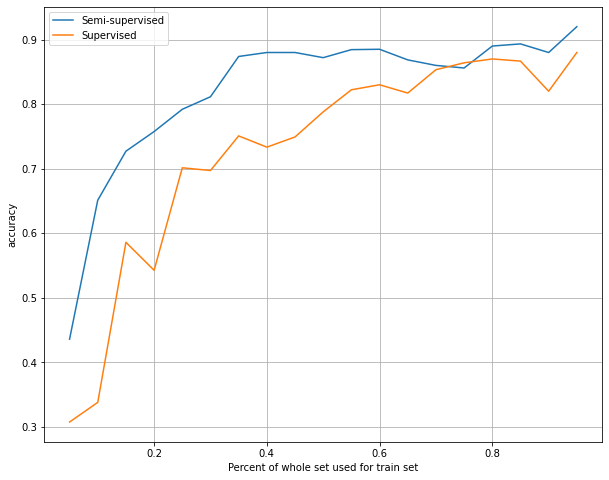

In [425]:
x = np.linspace(0,1,21)[1:-1]
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(x,accuracy_semi_supervised,label='Semi-supervised')
ax.plot(x,accuracy_supervised,label='Supervised')
ax.set(xlabel='Percent of whole set used for train set', ylabel='accuracy')
ax.plot()
ax.grid()
ax.legend()
plt.show()

#### We see that semi-supervised learning performs better both in terms of accuracy and execution time, the biggest gam being when only 20% of the dataset is known. In conclusion semi-supervised learning seems very efficient even compared to neural networks when there is few data.

# Exact vs Quantized

In this part, we compare Exact vs Quantized method for online learning. As before, for a varying training size which corresponds to the number of labeled nodes, we store labeled data in a centroid matrix, and we authorize 50 additionary unlabeled nodes as memory. We then reveal images one by one and classify using a modified version of online_face_recognition. We then compare this quantized approach to the approach in which memory is bigger than the set size, i.e bigger than 500 i.e illimited. We expect the exact method to perform better but with a much better computation time.

In [426]:
import cv2 as cv
import os
import numpy as np
from copy import copy

In [427]:
class IncrementalKCenters_version2:
    def __init__(self, labeled_faces, labels, label_names, max_num_centroids=100):
        #  Number of labels
        self.n_labels = max(labels)

        #  Dimension of the input image
        self.image_dimension = labeled_faces.shape[1]

        #  Check input validity
        assert (set(labels) == set(
            range(1, 1 + self.n_labels))), "Initially provided faces should be labeled in [1, max]"
        assert (len(labeled_faces) == len(labels)), "Initial faces and initial labels are not of same size"

        #  Number of labelled faces
        self.n_labeled_faces = len(labeled_faces)

        # Model parameter : number of maximum stored centroids
        self.max_num_centroids = max_num_centroids

        # Model centroids (inital labeled faces). Shape = (number_of_centroids, dimension)
        self.centroids = labeled_faces

        # Centroids labels
        self.Y = labels
        
        # Label names (= user names)
        self.label_names = label_names

        # Variables that are initialized in online_ssl_update_centroids()
        self.centroids_distances = None
        self.taboo = None
        self.V = None
        self.init = True

        # index of x_t (initialized later)
        self.last_face = None
    
        self.flag = 0 # self.flag corresponds to the number of consecutive "unknown" labels necessary to create a new label
        self.new_label = False
        self.new_faces = 0
        
    def initialize(self):
        """
        Initialization after the first time that the maximum number of centroids is reached.
        """       
        #  Compute the centroids distances
        self.centroids_distances = distance.cdist(self.centroids, self.centroids)

        #  set labeled nodes and self loops as infinitely distant, to avoid merging labeled centroids
        np.fill_diagonal(self.centroids_distances, +np.Inf)
        self.centroids_distances[0:self.n_labeled_faces, 0:self.n_labeled_faces] = +np.Inf

        # put labeled nodes in the taboo list
        self.taboo = np.array(range(self.centroids.shape[0])) < self.n_labeled_faces
        # initialize multiplicity
        self.V = np.ones(self.centroids.shape[0])
        

    def online_ssl_update_centroids(self, face):
        """
        TO BE COMPLETED

        Update centroids, multiplicity vector V, labels Y.
        
        Note: In Y, set label to 0 for unlabeled faces.

        Parameters
        ----------
        face : array
            New sample
        
        Returns
        --------
        List with the scores for each possible label:
            [(label_1, score_1), (label_2, score_2), ...]
        """
        
        assert (self.image_dimension == len(face)), "new image not of good size"

        # Case 1: maximum number of centroids has been reached.
        if self.centroids.shape[0] >= self.max_num_centroids + 1:
            if self.init:
                #  Initialization after the first time that the maximum number of centroids is reached
                self.initialize()
                self.init = False
            """
            Find c_rep and c_add following Algorithm 1.
            
            - c_1, c_2 = two closest centroids (minimum distance) such that at least one of them is not in self.taboo.
            - c_rep = centroid in {c_1, c_2} that is in self.taboo. If none of them is in self.taboo, c_rep is the one
                      with largest multiplicity.
            - c_add = centroid in {c_1, c_2} that is not c_rep.
            """
        
            c_rep, c_add = None, None
            num_centroid = self.centroids.shape[0]
            not_taboo =np.array(range(self.centroids.shape[0])) >= self.n_labeled_faces
            if len(not_taboo)>0 : 
                sorted_dist_centroid = np.argsort(self.centroids_distances[not_taboo].ravel())  
            else :
                sorted_dist_centroid = np.argsort(self.centroids_distances.ravel())
            sorted_dist_centroid = np.argsort(self.centroids_distances.ravel())
            ind=sorted_dist_centroid[0]
            c_1 = ind//num_centroid 
            c_2 = ind%num_centroid
            
            if c_1 in self.taboo:
                c_rep = c_1
                c_add = c_2
            elif c_2 in self.taboo:
                c_add = c_1
                c_rep = c_2
            elif self.V[c_2] <= self.V[c_1]:
                c_rep = c_1
                c_add = c_2
            else:
                c_add = c_1
                c_rep = c_2
            

            """
            Update data structures: self.centroids and self.V
            """
            self.centroids[c_add,:] = face 
            self.V[c_rep] += self.V[c_add]
            self.V[c_add] = 1


            """
            Update the matrix containing the distances.
            """
            dist_row = distance.cdist(np.array([self.centroids[c_add]]), self.centroids)[0]
            dist_row[c_add] = +np.inf
            self.centroids_distances[c_add, :] = dist_row
            self.centroids_distances[:, c_add] = dist_row
            self.last_face = c_add

        # Case 2: create new centroid with face
        # Remark: the multiplicities vector self.V is initialized in self.initialize()
        else:
            current_len = len(self.centroids)
            self.Y = np.append(self.Y, 0)
            self.centroids = np.vstack([self.centroids, face])

    def online_ssl_compute_solution(self):
        """
        TO BE COMPLETED.

        Returns a prediction corresponding to self.last_face.
        """

        # Multiplicity matrix
        if self.init:
            V = np.diag(np.ones(self.centroids.shape[0]))
            self.last_face = self.centroids.shape[0] - 1
        else:
            V = np.diag(self.V)
            
        # Build quantized graph and its regularized Laplacian
        
        W = build_similarity_graph(self.centroids,
                                   params_face_rec['var'], 
                                    params_face_rec['eps'], 
                                    params_face_rec['k'], 
                                  )
        
        W = V@W@V 
        L = build_laplacian(W, laplacian_normalization =  params_face_rec['laplacian_normalization'])
        Q = L + params_face_rec['laplacian_regularization']*np.eye(L.shape[0])

        # Compute the hard HFS solution f. 
        labels, f = compute_hfs(Q, self.Y, soft=True, **params_online_ssl)
          
        return labels[self.last_face]

In [428]:
def online_face_recognition_version2(images,
                            labels,
                            IncrementalKCenters,
                            n_pictures=50):
    
    
    

    label_names = [1,2,3,4,5,6,7,8,9,10]
    
    model = IncrementalKCenters(images[:n_pictures], labels[:n_pictures], label_names, n_pictures+50 )
    
    s = n_pictures
    
    label_list=copy(labels[:n_pictures])
    
    while s < 500 :
        
        x_t = images[s]

        """
        Centroids are updated here
        """
        model.online_ssl_update_centroids(x_t)

        """
        Hard HFS solution is computed here
        """
        
        label_predicted = model.online_ssl_compute_solution()
        
        
        label_list=np.append(label_list,np.array([label_predicted]))
        
        
        s+=1
    
    return label_list
        

In [429]:
time_start = time.time()
accuracy_online_quantized = []
for i in tqdm(np.linspace(0,1,11)[1:-1]) :
    ind1 = int(i*500)
    predicted_labels_semi_supervised = online_face_recognition_version2(images_a_shuffle,labels_a_shuffle,IncrementalKCenters_version2,ind1)
    accuracy_augmented = np.equal(predicted_labels_semi_supervised[ind1:], labels_a_shuffle[ind1:]).mean()
    accuracy_online_quantized.append(accuracy_augmented)
print('execution time = ', time.time()-time_start)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [06:46<00:00, 45.13s/it]

execution time =  406.1509807109833


In [430]:
def online_face_recognition_illimited(images,
                            labels,
                            IncrementalKCenters,
                            n_pictures=50):
    
    
    

    label_names = [1,2,3,4,5,6,7,8,9,10]
    
    model = IncrementalKCenters(images[:n_pictures], labels[:n_pictures], label_names, n_pictures+500 )
    
    s = n_pictures
    
    label_list=copy(labels[:n_pictures])
    
    while s < 500 :
        
        x_t = images[s]

        """
        Centroids are updated here
        """
        model.online_ssl_update_centroids(x_t)

        """
        Hard HFS solution is computed here
        """
        
        label_predicted = model.online_ssl_compute_solution()
        
        
        label_list=np.append(label_list,np.array([label_predicted]))
        
        s+=1
    
    return label_list
        

In [431]:
time_start = time.time()
accuracy_online_exact = []
for i in tqdm(np.linspace(0,1,11)[1:-1]) :
    ind1 = int(i*500)
    predicted_labels_semi_supervised = online_face_recognition_illimited(images_a_shuffle,labels_a_shuffle,IncrementalKCenters_version2,ind1)
    accuracy_augmented = np.equal(predicted_labels_semi_supervised[ind1:], labels_a_shuffle[ind1:]).mean()
    accuracy_online_exact.append(accuracy_augmented)
print('execution time = ', time.time()-time_start)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [12:56<00:00, 86.32s/it]

execution time =  776.8654179573059


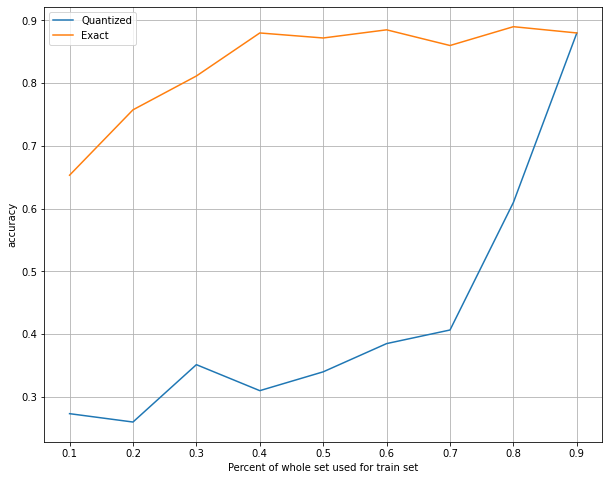

In [432]:
x = np.linspace(0,1,11)[1:-1]
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(x,accuracy_online_quantized,label='Quantized')
ax.plot(x,accuracy_online_exact,label='Exact')
ax.set(xlabel='Percent of whole set used for train set', ylabel='accuracy')
ax.plot()
ax.grid()
ax.legend()
plt.show()

We can see that the Exact method for online learning yields much better accuracy, especially when we give our learner few data and let him learn all the rest image by image. Unless we give our quantized learner 90% of the set as labels, the Exact method is far superior in terms of accuracy. On the other hand, the exact method is almost twice slower.

# Summury
Let's summurize these different tradeoffs by comparing Exact online learning, Quantized online learning, Supervised learning, Semi-supervised learning and their performances depending of the percentage of labeled nodes given to our model.

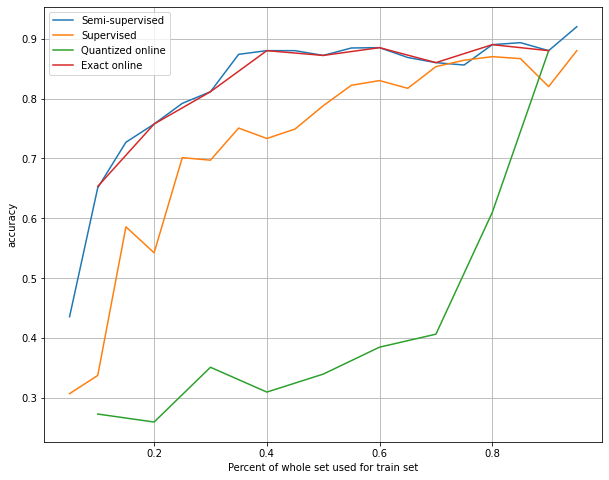

In [434]:
x = np.linspace(0,1,11)[1:-1]
z = np.linspace(0,1,21)[1:-1]
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(z,accuracy_semi_supervised,label='Semi-supervised')
ax.plot(z,accuracy_supervised,label='Supervised')
ax.plot(x,accuracy_online_quantized,label='Quantized online')
ax.plot(x,accuracy_online_exact,label='Exact online')
ax.set(xlabel='Percent of whole set used for train set', ylabel='accuracy')
ax.plot()
ax.grid()
ax.legend()
plt.show()